In this notebook, we consider the following nonlinar autonomous ODE system: $\frac{dx}{dt} = 10x - 5xy$, $ \frac{dy}{dt} = 3y + xy - 3y^2$. We train an PINN-based MLP to solve this system for $t \in [0, 1]$ and $x_0, y_0 \in [0, 5]$ and investigate its extrapolation behavior on $t \in [1, 5]$.

In [1]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
matplotlib.rcParams.update({'font.family': 'serif', 'font.size': 10})
matplotlib.rcParams['text.usetex'] = True
from matplotlib.lines import Line2D

from scipy.interpolate import griddata
from scipy import integrate
import time

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    
    def __init__(self, layers):
        
        super().__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    
    
    def forward(self, x):
        
        # x = (t, y0)
        return self.layers(x)

In [4]:
# PINN: physics-informed neural network
class PINN():

    def __init__(self, X_pinn, X_semigroup, X_smooth, layers, T):

        # neural network architecture
        self.layers = layers
        self.dnn = DNN(layers).to(device)
        
        # semigroup PINN step time
        self.T = torch.tensor(T).float().to(device)

        # training data
        self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
        self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
        
        self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
        self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
        self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
        
        self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
        self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
        
        # optimization
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), lr=1.0, max_iter=50000, max_eval=50000, 
            history_size=50, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
    
    
    def net_y(self, t, y0):
        
        # The M(t, y0) = y0 + t N(t, y0) scheme seems to drastically increase the accuracy
        # This works perfectly fine with automatic differentiation
        y = y0 + t * self.dnn(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivative of the neural network
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output dimension
        vectors = [torch.zeros_like(y) for i in range(2)]
        
        for i, vec in enumerate(vectors):
            
            vec[:,i] = 1.
        
        # list of derivative tensors
        # the first entry is a tensor with \partial_t PINN(t, y0) for all (t, y0) in the batch,
        # each input (t, y0) corresponds to one row in each tensor
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        y_pred = self.net_y(self.t_pinn, self.y_pinn)
        deriv_pred = self.net_derivative(self.t_pinn, self.y_pinn)
        
        """ Changed this """

        # in our case, dy1/dt = 10 * y1 - 5 * y1 * y2, dy2/dt = 3 * y2 + y1 * y2 - 3 y2 ** 2
        loss_pinn1 = torch.mean((deriv_pred[0] - 10 * y_pred[:,0:1] + 5 * y_pred[:,0:1] * y_pred[:,1:2]) ** 2)
        loss_pinn2 = torch.mean((deriv_pred[1] - y_pred[:,0:1] * y_pred[:,1:2] - 3 * y_pred[:,1:2] + 3 * y_pred[:,1:2] ** 2) ** 2)
        loss_pinn = loss_pinn1 + loss_pinn2 
        
        # The general semigroup loss for autonomous ODEs
        y_pred_tps = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_pred_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_pred_restart = self.net_y(self.t_semigroup, y_pred_s)
        loss_semigroup = torch.mean((y_pred_tps - y_pred_restart) ** 2)
        
        # The smoothness loss
        y_pred_smooth = self.net_y(self.t_smooth, self.y_smooth)
        deriv_pred_below = self.net_derivative(self.t_smooth, self.y_smooth)
        deriv_pred_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y_pred_smooth)
        
        loss_smooth = .0
        
        for t1, t2 in zip(deriv_pred_below, deriv_pred_above):
            
            loss_smooth += torch.mean((t1 - t2) ** 2)
        
        loss = loss_pinn + loss_smooth + loss_semigroup
        
        loss.backward()
        self.iter += 1
        
        if self.iter % 100 == 0:
            print(
                f"Iter {self.iter}, Loss: {loss.item():.5f}, Loss_pinn: {loss_pinn.item():.5f} " \
                f"Loss_smooth: {loss_smooth.item():.5f}, Loss_semigroup: {loss_semigroup.item():.5f}"
            )
        
        return loss
    
    
    def train(self):
        
        self.dnn.train()
        self.optimizer.step(self.loss_function)
    
    
    def predict(self, t, y0):
        
        t = torch.tensor(t, requires_grad=True).float().to(device)
        y0 = torch.tensor(y0, requires_grad=True).float().to(device)
        
        self.dnn.eval()
        y = self.net_y(t, y0)
        y = y.detach().cpu().numpy()
        
        return y

### Setup data example

In [24]:
""" Changed the net to 6 x 64 """

layers = [3, 64, 64, 64, 64, 64, 64, 2]

T = 1
max_y0 = 5

# standard PINN loss function training samples
N_pinn = 10000
N_semigroup = 10000
N_smooth = 10000


t_pinn = np.random.uniform(0, T, (N_pinn, 1))
y_pinn = np.random.uniform(0, max_y0, (N_pinn, 2))
X_pinn = np.hstack([t_pinn, y_pinn])


r1 = np.random.uniform(0, 1, N_semigroup)
r2 = np.random.uniform(0, 1, N_semigroup)
s_semigroup, t_semigroup = np.sqrt(r1) * (1 - r2), r2 * np.sqrt(r1)
s_semigroup, t_semigroup = T * s_semigroup[:, np.newaxis], T * t_semigroup[:, np.newaxis]
y_semigroup = np.random.uniform(0, max_y0, (N_semigroup, 2))
X_semigroup = np.hstack([s_semigroup, t_semigroup, y_semigroup])


t_smooth = np.random.uniform(0, T, (N_smooth, 1))
y_smooth = np.random.uniform(0, max_y0, (N_smooth, 2))
X_smooth = np.hstack([t_smooth, y_smooth])

In [25]:
model = PINN(X_pinn, X_semigroup, X_smooth, layers, T)

In [26]:
# train the model from scratch or load an already trained model (next cell)

%%time
               
model.train()

Iter 100, Loss: 11.30256, Loss_pinn: 9.48781 Loss_smooth: 1.80623, Loss_semigroup: 0.00852
Iter 200, Loss: 3.99790, Loss_pinn: 3.44510 Loss_smooth: 0.54836, Loss_semigroup: 0.00444
Iter 300, Loss: 2.62672, Loss_pinn: 2.29249 Loss_smooth: 0.32750, Loss_semigroup: 0.00673
Iter 400, Loss: 1.97989, Loss_pinn: 1.68509 Loss_smooth: 0.29044, Loss_semigroup: 0.00436
Iter 500, Loss: 1.52676, Loss_pinn: 1.30584 Loss_smooth: 0.21558, Loss_semigroup: 0.00534
Iter 600, Loss: 1.16467, Loss_pinn: 0.96012 Loss_smooth: 0.19978, Loss_semigroup: 0.00477
Iter 700, Loss: 0.87106, Loss_pinn: 0.70453 Loss_smooth: 0.16092, Loss_semigroup: 0.00562
Iter 800, Loss: 0.66418, Loss_pinn: 0.50428 Loss_smooth: 0.15267, Loss_semigroup: 0.00724
Iter 900, Loss: 0.50686, Loss_pinn: 0.37791 Loss_smooth: 0.11850, Loss_semigroup: 0.01045
Iter 1000, Loss: 0.41325, Loss_pinn: 0.30611 Loss_smooth: 0.09900, Loss_semigroup: 0.00814
Iter 1100, Loss: 0.34682, Loss_pinn: 0.26307 Loss_smooth: 0.07402, Loss_semigroup: 0.00973
Iter 12

## Predict and Plot the Solution

In [27]:
def predict_standard(model, y0, max_t_pred, delta_t):
    
    times = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
    times = times[:,np.newaxis]
    
    y0 = np.array([y0 for _ in range(len(times))])
    trajectory =  model.predict(times, y0)
    
    return trajectory


def predict_dac(model, y0, max_t_pred, delta_t):
    """
    detla_t should devide model.max_t to guarantee equidistant steps
    """
    times = np.arange(0, 1 + delta_t, delta_t)[1:] # replaced model.T with 1
    times = times[:,np.newaxis]
    n_resets = int(np.ceil(max_t_pred / 1))
    
    trajectory = np.array([y0])
    
    for _ in range(n_resets):
        
        y0 = trajectory[-1]
        y0 = np.array([y0 for _ in range(len(times))])
        segment =  model.predict(times, y0)
        trajectory = np.vstack([trajectory, segment])
    
    return trajectory

In [28]:
# Note that max_t in training is 1

y0 = [2.0, 5.0]
max_t_pred = 5
delta_t = 0.01

validation_dac = predict_dac(model, y0, max_t_pred, delta_t)
validation_standard = predict_standard(model, y0, max_t_pred, delta_t)

In [29]:
# compute true solution

def func(t, r):
    x, y = r
    dx_t = 10 * x - 5 * x * y
    dy_t = 3 * y + x * y - 3 *y **2
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)

    sol = integrate.solve_ivp(func, (0, 5), (y0[0], y0[1]), t_eval=t) 
    x_true, y_true = sol.y

    return np.stack((x_true, y_true), axis = 1)


true_solution = gen_truedata()

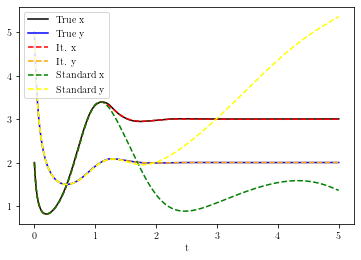

In [30]:
# plot the results and compare with the true solution

#plt.xlabel("t")
#plt.ylabel("population")

t = np.linspace(0, 5, 501)
x_true = true_solution[:, 0]
y_true = true_solution[:, 1]

plt.plot(t, x_true, color="black", label='True x')
plt.plot(t, y_true, color="blue", label='True y')


x_pred = validation_dac[:, 0]
y_pred = validation_dac[:, 1]

x_standard = validation_standard[:, 0]
y_standard = validation_standard[:, 1]

plt.plot(t, x_pred, color="red", linestyle="dashed", label='It. x')
plt.plot(t, y_pred, color="orange", linestyle="dashed", label='It. y')

plt.plot(t, x_standard, color="green", linestyle="dashed", label='Standard x')
plt.plot(t, y_standard, color="yellow", linestyle="dashed", label='Standard y')

plt.legend(loc='upper left')
plt.xlabel("t")
plt.show()

In [12]:
# might have to install these packages for visualization purposes before running the previous cell

! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0 libkpathsea6
  libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  poppler-utils ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc
  texlive-luatex texlive-pstricks
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern f

In [13]:
!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal pfb2t1c2pfb
The following NEW packages will be installed:
  cm-super cm-super-minimal pfb2t1c2pfb
0 upgraded, 3 newly installed, 0 to remove and 23 not upgraded.
Need to get 24.5 MB of archives.
After this operation, 59.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 cm-super-minimal all 0.3.4-15 [5,811 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 pfb2t1c2pfb amd64 0.3-11 [9,342 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 cm-super all 0.3.4-15 [18.7 MB]
Fetched 24.5 MB in 3s (9,313 kB/s)
Selecting previously unselected package cm-super-minimal.
(Reading database ... 158692 files and directories currently installed.)
Preparing to unpack .../cm-super-minimal_0.3.4-15_all.deb ...
Unpacking cm-super-minimal (0.3.4-15) ...
Selecting 